# BEM114 Homework 3 - Value of Intangibles
**Names:** Andrew Zabelo, Daniel Wen, Kyle McCandless  
**Student IDs:** 2176083, 2159859, 2157818

## Setup

### Imports and Helper Functions

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Gets the next month from a date string
def get_next_month_str(d1):
    return (datetime.strptime(d1, "%Y-%m") + relativedelta(months=1)).strftime("%Y-%m")

def is_next_month(d1, d2):
    return d2 == get_next_month_str(d1)

# Briefly test is_next_month
assert is_next_month('1986-05', '1986-06')
assert is_next_month('2012-12', '2013-01')
assert is_next_month('1999-12', '2000-01')
assert not is_next_month('1986-04', '1986-06')
assert not is_next_month('1998-04', '1999-05')
assert not is_next_month('1984-01', '1986-10')

# Given a group of stocks, calculate equal-weighted and value-weighted weights
def calc_weights(group):
    if group['rebalance'].sum() > 0:
        # Calc equal weights
        group['weights_eq'] = 1 / float(group['PERMNO'].count())
        assert(group['PERMNO'].count() == group['PERMNO'].nunique())
        # Calc value weights
        group['weights_val'] = group['MV'] / group['MV'].sum()
        return group
    else:
        group['weights_eq'] = np.nan
        group['weights_val'] = np.nan
        return group
    
# Adds a final month of 0 returns any time a stock becomes de-listed
def add_padding_month(group):
    # Sorted list of dates in this group
    dates_list = sorted([''.join(str_list) for str_list in group['date'].agg(list)])
    
    # Collect de-listing dates
    dates_to_add = [group['date'].max()] 
    prev_date = dates_list[0]
    for date in dates_list[1:]:
        if not is_next_month(prev_date, date):
            dates_to_add.append(prev_date)
        prev_date = date
    
    # Add new padding rows for the month after each de-listing date
    new_rows = []
    for date in dates_to_add:
        new_row = pd.Series({'company': group['company'].iloc[0],
                             'PERMNO': group['PERMNO'].iloc[0],
                             'date': get_next_month_str(date),
                             'RET': 0.0,
                             'MV': 1.0})
        new_rows.append(new_row)
        
    return pd.concat([group, pd.DataFrame(new_rows)], ignore_index=True)

# Calculates returns and prints the returns mean, vol, and Sharpe ratio for a strategy
def analyze(returns, strat_name):
    strat_mean = returns.mean()
    strat_vol = returns.std()
    strat_sharpe = strat_mean / strat_vol
    print(f"{strat_name} monthly returns:\nMean = {strat_mean}%\nVolatility = {strat_vol}%\nSharpe Ratio = {strat_sharpe}")
    
# Estimates the CAPM and FF3 models on df_old using the returns found in ret_col_name
def estimate_models(df_old, return_col_name, ff5_mom):
    df = pd.merge(df_old, ff5_mom, how='inner', on=['date'])
    assert(len(df) == len(df_old))
    
    # Estimate CAPM
    print('CAPM')
    capm_model = sm.OLS(df[return_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF']])).fit()
    capm_beta = capm_model.params['Mkt-RF']
    print(capm_model.summary())
    
    # Estimate FF3
    print('FF3')
    print(sm.OLS(df[return_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML']])).fit().summary())
    
    # Estimate Carhart
    print('Carhart')
    print(sm.OLS(df[return_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'MOM']])).fit().summary())
    
    # Estimate FF5
    print('FF5')
    print(sm.OLS(df[return_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])).fit().summary())
    
    return capm_beta
    
# Plots the cumulative returns for a strategy versus the CAPM-implied returns
def plot_cum_returns(df, return_col_name, capm_beta, title):
    df[return_col_name + '_MIR'] = df['RF'] + capm_beta * df['Mkt-RF']
    
    dates = df['date'] // 100 + (df['date'] % 100) / 12
    strategy_cumulative = (df[return_col_name] / 100 + 1.0).cumprod()
    mir_cumulative = (df[return_col_name + '_MIR'] / 100 + 1.0).cumprod()

    plt.figure()
    plt.plot(dates, strategy_cumulative, label=f'{return_col_name} Portfolio Value')
    plt.plot(dates, mir_cumulative, label=f'CAPM-Implied Portfolio Value')

    plt.title(f'{title} Model Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Portfolio Value')

    plt.legend()
    plt.show()

### Process Dataframes

In [3]:
'''
Load CRSP data
'''

crsp = pd.read_csv('crsp_1926_2020.zip')

# Convert prices and returns to numeric and drop NaNs
crsp['PRC'] = pd.to_numeric(crsp['PRC'], errors='coerce')
crsp['RET'] = pd.to_numeric(crsp['RET'], errors='coerce')
crsp = crsp.dropna(subset=['PRC', 'RET'])

# Set types for relevant columns
crsp = crsp.astype({'date': 'string', 'SHRCD': 'int', 'EXCHCD': 'int'})

# [From HW2] Filter SHRCD and EXCHCD
crsp = crsp[crsp['SHRCD'].isin([10, 11])]
crsp = crsp[crsp['EXCHCD'].isin([1, 2, 3])]

# Reformat date column and add market value column
crsp['date'] = crsp['date'].str[:-3]
crsp['year'] = crsp['date'].str[:-3].astype('int')
crsp['MV'] = np.abs(crsp['PRC']) * crsp['SHROUT']
crsp['RET'] *= 100
crsp

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT,year,MV
2,10000,1986-02,10,3,-3.25000,-25.7143,3680.0,1986,1.196000e+04
3,10000,1986-03,10,3,-4.43750,36.5385,3680.0,1986,1.633000e+04
4,10000,1986-04,10,3,-4.00000,-9.8592,3793.0,1986,1.517200e+04
5,10000,1986-05,10,3,-3.10938,-22.2656,3793.0,1986,1.179388e+04
6,10000,1986-06,10,3,-3.09375,-0.5025,3793.0,1986,1.173459e+04
...,...,...,...,...,...,...,...,...,...
4705164,93436,2020-08,11,3,498.32001,74.1452,931809.0,2020,4.643391e+08
4705165,93436,2020-09,11,3,429.01001,-13.9087,948000.0,2020,4.067015e+08
4705166,93436,2020-10,11,3,388.04001,-9.5499,947901.0,2020,3.678235e+08
4705167,93436,2020-11,11,3,567.59998,46.2736,947901.0,2020,5.380286e+08


In [4]:
'''
Load FF5 and Industries data
'''

ff5 = pd.read_csv('ff5_factors.csv')
ff5 = ff5.astype({'date': 'string'})
ff5['date'] = ff5['date'].apply(lambda x: x[:4] + '-' + x[4:])

mom = pd.read_csv('F-F_Momentum_Factor.CSV')
mom = mom.astype({'date': 'string'})
mom['date'] = mom['date'].apply(lambda x: x[:4] + '-' + x[4:])

ff5_mom = pd.merge(ff5, mom, on='date', how='inner')
assert len(ff5_mom) == len(ff5)
ff5_mom

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM
0,1963-07,-0.39,-0.41,-0.97,0.68,-1.18,0.27,0.90
1,1963-08,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01
2,1963-09,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19
3,1963-10,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12
4,1963-11,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74
...,...,...,...,...,...,...,...,...
723,2023-10,-3.19,-4.05,0.19,2.46,-0.66,0.47,1.73
724,2023-11,8.84,-0.12,1.64,-3.91,-1.00,0.44,2.75
725,2023-12,4.87,7.32,4.93,-3.07,1.32,0.43,-5.51
726,2024-01,0.71,-5.74,-2.38,0.69,-0.96,0.47,5.18


In [5]:
'''
Load 100 Best Companies to Work for in America
'''

bcw = pd.read_csv('bcwlist_modified.csv')
bcw = bcw.dropna(subset=['permno'])

# Set types for relevant columns
bcw = bcw.astype({'rank': 'int', 'company': 'string', 'year': 'int'})
bcw.rename(columns={'permno': 'PERMNO'}, inplace=True)
bcw = bcw.sort_values(by=['year', 'rank'])
bcw

,rank,company,PERMNO,year
0,1,AT&T Bell Laboratories,66093.0,1984
1,2,Trammell Crow Company,85629.0,1984
2,3,Delta Airlines,26112.0,1984
3,4,Federal Express,60628.0,1984
4,5,Goldman Sachs,86868.0,1984
...,...,...,...,...
2486,87,AbbVie,13721.0,2020
2487,88,Encompass Home Health & Hospice,10693.0,2020
2493,94,Goldman Sachs,86868.0,2020
2498,99,Delta Airlines,91926.0,2020


## Problem 1

### Part A - Process

**Data cleaning:**
* Filter CRSP to ordinary/common shares (SHRCD = 10 or 11) and NYSE, AMEX, and NASDAQ stocks (EXCHCD = 1, 2, or 3)]
* Do not filter out CRSP negative prices. We only need returns, and even if one month's return bid-ask midpoint estimate is slightly off, that won't affect the portfolio's performance at the end of the next month when the stock is traded
* Assume that if no BCW PERMNO then not publicly traded and remove from dataset
* Augment bcw dataframe with all years a portfolio will be active. For example, the portfolio formed in 1984 is active in 1985, 1986, ... 1992.

**Calculating weights:**
* Merge CRSP data with bcw dataframe on year, so that monthly price data for all stocks in an active best companies portfolio are present
* Create **rebalance column:** True if rebalancing based on stock prices that month, false otherwise. Rebalancing is true iff it is January the year the portfolio was formed or a stock is listed or delisted in that month.
* Apply calc_weights, which rebalances the entire portfolio if rebalancing == True, and if not returns NaN weights.
* After sorting by PERMNO and date Fill NaN weights with the first non-NaN weights above them, keeping the weights the same for months where we don't rebalance the portfolio. One stock's weights can never be filled with the weights of another since the earliest date of any stock always has rebalance == True
* Pad all stocks that are de-listed at any time(s) with an extra month of 0 returns
* Shift weights down by one date for each stock. For de-listing months, the previous month's weights occupy the padded month as desired, since the portfolio will carry the stock with 0 returns during the month it is de-listed, then be updated next month. For listing months, the weights from the first month the stock is present are shifted down to form the portfolio for the next month

**Calculating returns:**
* As in HW2, multiply the returns of each stock with its lagged weights, which are the weights the portfolio started that month with

In [6]:
# Prepare bcw for merge by adding years between 1984 - 1993, 1993 - 1998
bcw['year_formed'] = bcw['year']

bcw_extra = []
for year_formed, gap_length in zip([1984, 1993], [1993 - 1984, 1998 - 1993]):
    to_increment = bcw[bcw['year_formed'] == year_formed]
    for increment in range(1, gap_length):
        for _, row in to_increment.iterrows():
            row['year'] += increment
            bcw_extra.append(row.to_dict())

bcw_extra = pd.DataFrame(bcw_extra, columns=bcw.columns)
bcw = pd.concat([bcw, bcw_extra], ignore_index=True)
bcw

,rank,company,PERMNO,year,year_formed
0,1,AT&T Bell Laboratories,66093.0,1984,1984
1,2,Trammell Crow Company,85629.0,1984,1984
2,3,Delta Airlines,26112.0,1984,1984
3,4,Federal Express,60628.0,1984,1984
4,5,Goldman Sachs,86868.0,1984,1984
...,...,...,...,...,...
2320,101,Viking Freight System,80814.0,1997,1993
2321,101,Wal-Mart Stores,55976.0,1997,1993
2322,101,Weyerhaeuser Company,39917.0,1997,1993
2323,101,Worthington Industries,83601.0,1997,1993


In [7]:
# Merge bcw and crsp
df = pd.merge(bcw, crsp, how='inner', on=['year', 'PERMNO'])
df = df.sort_values(by=['PERMNO', 'date'])

# Find dates where firms were listed and de-listed
special_dates = set(df.groupby('PERMNO')['date'].min().tolist())
last_trade_dates = df.groupby('PERMNO')['date'].max().tolist()
for date in last_trade_dates:
    special_dates.add(get_next_month_str(date))

# Add to special dates if any firms are de-listed then listed again
prev_row = df.iloc[0]
for _, row in df.iloc[1:].iterrows():
    if (not is_next_month(prev_row['date'], row['date'])) and (prev_row['PERMNO'] == row['PERMNO']):
        special_dates.add(get_next_month_str(prev_row['date']))
        special_dates.add(row['date'])
    prev_row = row
    
# Add rebalance column -- rebalance if its January when the portfolio was formed or if its a special date
df['rebalance'] = (df['date'].str[-2:] == '01') | (df['date'].isin(special_dates))

df = df.drop(['rank', 'SHRCD', 'EXCHCD', 'PRC', 'SHROUT'], axis=1)
df = df.sort_values(by=['date'])
df

,company,PERMNO,year,year_formed,date,RET,MV,rebalance
562,Moog,61807.0,1984,1984,1984-01,-15.0000,8.582875e+04,True
394,Inland Steel Company,12458.0,1984,1984,1984-01,-3.2258,7.469400e+05,True
490,Liebert Corporation,49411.0,1984,1984,1984-01,1.7857,3.116048e+05,True
154,Armstrong,19692.0,1984,1984,1984-01,-5.4299,6.469856e+05,True
70,Time,40483.0,1984,1984,1984-01,-8.9417,2.671005e+06,True
...,...,...,...,...,...,...,...,...
13271,Hilton,14338.0,2020,2020,2020-12,7.3627,3.086864e+07,False
13379,CarMax,89508.0,2020,2020,2020-12,1.0483,1.540019e+07,False
13331,American Express,59176.0,2020,2020,2020-12,1.9563,9.735697e+07,False
13391,Capital One Financial,81055.0,2020,2020,2020-12,15.4250,4.521369e+07,False


In [8]:
# Group by date and calculate weights
df_weights = df.groupby('date', group_keys=False).apply(calc_weights)

# Assert that calc_weights is returning weights when rebalance is needed only
assert len(df_weights[(df_weights['rebalance'] == True) & (np.isnan(df_weights['weights_eq']))]) == 0
assert len(df_weights[(df_weights['rebalance'] == True) & (np.isnan(df_weights['weights_val']))]) == 0

# Fill the NaNs returned from calc_weights when there are no rebalances
# using the weights for that PERMNO on the previous date
df_weights = df_weights.sort_values(['PERMNO', 'date'])
df_weights['weights_eq'] = df_weights['weights_eq'].fillna(method='ffill')
df_weights['weights_val'] = df_weights['weights_val'].fillna(method='ffill')

# Pad all stocks with 1 extra month of 0 returns for weight shift
df_weights = df_weights.groupby('PERMNO').apply(add_padding_month).reset_index(drop=True)

# Shift weights
df_weights = df_weights.sort_values(['PERMNO', 'date'])
df_weights['weights_eq_lag'] = df_weights.groupby('PERMNO')['weights_eq'].shift(1)
df_weights['weights_val_lag'] = df_weights.groupby('PERMNO')['weights_val'].shift(1)
df_weights = df_weights.dropna(subset=['weights_eq_lag', 'weights_val_lag'])

# Assert that weights add up to one for all dates
test1 = df_weights.groupby('date')['weights_eq_lag'].sum()
test2 = df_weights.groupby('date')['weights_val_lag'].sum()
assert test1.apply(lambda x: np.isclose(x, 1.0, atol=0.00001)).all()
assert test2.apply(lambda x: np.isclose(x, 1.0, atol=0.00001)).all()

df_weights = df_weights.drop(['year', 'MV'], axis=1)
df_weights = df_weights.sort_values(['date', 'PERMNO'])
df_weights

,company,PERMNO,year_formed,date,RET,rebalance,weights_eq,weights_val,weights_eq_lag,weights_val_lag
402,Atlantic Richfield Company,10604.0,1984.0,1984-02,-0.5525,False,0.014085,0.038332,0.014085,0.038332
710,Dana Corporation,11607.0,1984.0,1984-02,-13.3739,False,0.014085,0.005508,0.014085,0.005508
893,Du Pont,11703.0,1984.0,1984-02,-3.3668,False,0.014085,0.040308,0.014085,0.040308
1062,Eastman Kodak Company,11754.0,1984.0,1984-02,-5.8319,False,0.014085,0.040958,0.014085,0.040958
1171,Exxon Corporation,11850.0,1984.0,1984-02,-1.1321,False,0.014085,0.114076,0.014085,0.114076
...,...,...,...,...,...,...,...,...,...,...
22660,Salesforce.com,90215.0,NaN,2021-01,0.0000,<NA>,NaN,NaN,0.029412,0.085811
23068,Delta Airlines,91926.0,NaN,2021-01,0.0000,<NA>,NaN,NaN,0.029412,0.019130
23105,T-Mobile US,91937.0,NaN,2021-01,0.0000,<NA>,NaN,NaN,0.029412,0.036010
23305,Hyatt Hotels Corporation,93098.0,NaN,2021-01,0.0000,<NA>,NaN,NaN,0.029412,0.001641


## Problem 2

### Part A

In [9]:
# Add returns
df_weights['weighted_eq_ret'] = df_weights['weights_eq_lag'] * df_weights['RET']
df_weights['weighted_val_ret'] = df_weights['weights_val_lag'] * df_weights['RET']

eq_returns = df_weights.groupby('date')['weighted_eq_ret'].sum()
val_returns = df_weights.groupby('date')['weighted_val_ret'].sum()

analyze(eq_returns, "Equal-weighted Best Companies")
print()
analyze(val_returns, "Value-weighted Best Companies")

Equal-weighted Best Companies monthly returns:
Mean = 1.220920902080068%
Volatility = 5.403471378171253%
Sharpe Ratio = 0.22595121110704866

Value-weighted Best Companies monthly returns:
Mean = 1.0771412191404004%
Volatility = 5.264385220495521%
Sharpe Ratio = 0.20460911844878485


### Part B

In [10]:
eq_capm_beta = estimate_models(eq_returns, 'weighted_eq_ret', ff5_mom)

CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     3653.
Date:                Thu, 25 Apr 2024   Prob (F-statistic):          8.79e-216
Time:                        23:13:08   Log-Likelihood:                -885.39
No. Observations:                 444   AIC:                             1775.
Df Residuals:                     442   BIC:                             1783.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1085      0.086      1.267    

In [11]:
val_capm_beta = estimate_models(val_returns, 'weighted_val_ret', ff5_mom)

CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     2220.
Date:                Thu, 25 Apr 2024   Prob (F-statistic):          1.90e-174
Time:                        23:13:08   Log-Likelihood:                -968.65
No. Observations:                 444   AIC:                             1941.
Df Residuals:                     442   BIC:                             1949.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0145      0.103      0.140    

The equal-weighted and value-weighted portfolios produce alphas that are positive but insignificant under all four models.

### Part C

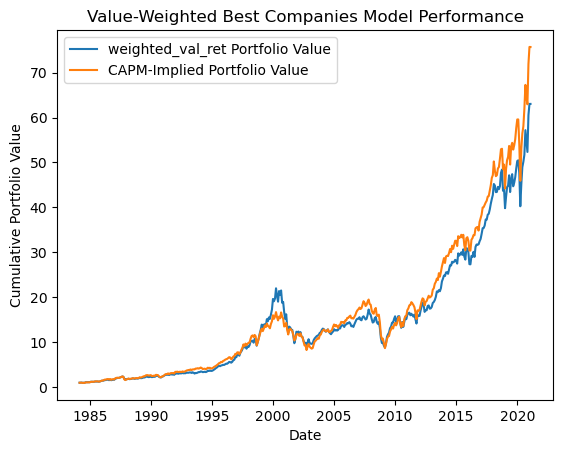

In [12]:
val_ff5 = pd.merge(val_returns.to_frame(), ff5, how='inner', on=['date'])
assert len(val_ff5) == len(val_returns)

val_ff5['date'] = (val_ff5['date'].str[:4] + val_ff5['date'].str[5:]).astype('int')

plot_cum_returns(val_ff5, 'weighted_val_ret', eq_capm_beta, 'Value-Weighted Best Companies')

The strategy is performing similar, but slightly lower returns. Alpha not significant so idk why this would be good

### Part D

In [13]:
eq_returns_pre_jan1 = eq_returns[eq_returns.index < '2010-01']
eq_returns_post_jan1 = eq_returns[eq_returns.index >= '2010-01']

val_returns_pre_jan1 = val_returns[val_returns.index < '2010-01']
val_returns_post_jan1 = val_returns[val_returns.index >= '2010-01']

In [14]:
estimate_models(eq_returns_pre_jan1, 'weighted_eq_ret', ff5_mom)

CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     2599.
Date:                Thu, 25 Apr 2024   Prob (F-statistic):          1.84e-152
Time:                        23:13:08   Log-Likelihood:                -624.62
No. Observations:                 311   AIC:                             1253.
Df Residuals:                     309   BIC:                             1261.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1791      0.103      1.733    

1.1456255645790132

In [15]:
estimate_models(val_returns_pre_jan1, 'weighted_val_ret', ff5_mom)

CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     1436.
Date:                Thu, 25 Apr 2024   Prob (F-statistic):          3.57e-118
Time:                        23:13:08   Log-Likelihood:                -696.81
No. Observations:                 311   AIC:                             1398.
Df Residuals:                     309   BIC:                             1405.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0763      0.130      0.585    

1.07400676934913

In [23]:
estimate_models(eq_returns_post_jan1, 'weighted_eq_ret', ff5_mom)

CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1043.
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           2.98e-64
Time:                        23:25:00   Log-Likelihood:                -259.57
No. Observations:                 133   AIC:                             523.1
Df Residuals:                     131   BIC:                             528.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0552      0.154     -0.358    

1.135639057256818

In [24]:
estimate_models(val_returns_post_jan1, 'weighted_val_ret', ff5_mom)

CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     844.6
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           5.71e-59
Time:                        23:25:04   Log-Likelihood:                -266.55
No. Observations:                 133   AIC:                             537.1
Df Residuals:                     131   BIC:                             542.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1346      0.163     -0.827    

1.0767224921961434

The strategy worked well before January 1st, 2010. The alphas were positive for the equal and value weighted strategies, and statistically significant at the 1% level when tested using the Carhart model. The alphas and their significance levels, as well as the coefficients, are strikingly similar to the paper. However, we note that the Carhart model provides the most positive and significant alphas, and under the other models especially CAPM and FF3, the alphas are not nearly as high.

The strategy does not work in the post-period, and has negative alphas under both strategies and all models with the exception of the equal weighted portfolio under FF5, which is positive

### Part E

In [22]:
'''
Load Industry portfolio data from Ken French's website. Using monthly value-weighted industry portfolios.
'''

industries = pd.read_csv('12_Industry_Portfolios.CSV')
industries = industries.astype({'date': 'string'})
industries['date'] = industries['date'].apply(lambda x: x[:4] + '-' + x[4:])
industries

val_returns_pre_1999 = val_returns[val_returns.index < '1999-01']
val_returns_post_1999 = val_returns[val_returns.index >= '1999-01']

df_pre = pd.merge(industries, val_returns_pre_1999, on=["date"], how="inner")
df_pre = pd.merge(df_pre, ff5_mom, on=["date"], how="inner")
assert len(df_pre) == len(val_returns_pre_1999)

df_post = pd.merge(industries, val_returns_post_1999, on=["date"], how="inner")
df_post = pd.merge(df_post, ff5_mom, on=["date"], how="inner")
assert len(df_post) == len(val_returns_post_1999)

print('Pre-1999')
print(sm.OLS(df_pre['weighted_val_ret'] - df_pre['RF'], sm.add_constant(df_pre[['NoDur','Durbl','Manuf','Enrgy','Chems','BusEq','Telcm','Utils','Shops','Hlth','Money','Other']])).fit().summary())

print('Post-1999')
print(sm.OLS(df_post['weighted_val_ret'] - df_post['RF'], sm.add_constant(df_post[['NoDur','Durbl','Manuf','Enrgy','Chems','BusEq','Telcm','Utils','Shops','Hlth','Money','Other']])).fit().summary())

Pre-1999
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     189.5
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           3.62e-90
Time:                        23:22:00   Log-Likelihood:                -291.15
No. Observations:                 179   AIC:                             608.3
Df Residuals:                     166   BIC:                             649.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4601      0.105     -4.366

Yes, based on the regression it appears that the composition of the best companies to work for has somewhat changed over time. Prior to Jan 1, 1999, the value weighted returns had statistically significant (1%) and sizable positive coefficients (>0.1) with the NoDur, Enrgy, Chems, BusEq, and Hlth industries. After Jan 1, 1999, the value weighted returns had statistically significant (1%) and sizable positive coefficients (>0.1) with the BusEQ, Utils, Hlth, and Money industries.

## Problem 3

### Part A

The beta of the equal-weighted and value-weighted strategies is close to 1. We are just buying a bunch of market assets, which will have a beta of roughly 1. We haven't shorted anything yet.

A long-short portfolio is more hedged against market risk, which would make it attractive to institutional investors. At the same time, shorting stocks with positive beta would decrease the expected returns of the strategy, making it less attractive to retail investors.

### Part B

As we can see from the results, estimating the Carhart model from the long portfolio on the best companies to work with (the companies with the highest employee satisfaction) produces a positive alpha that is significant at the 1% level, for both the equal-weighted and value-weighted portfolios. This shows that financial markets do not fully price the value of employee satisfaction.

### Part C

One possible reason for why the alpha decreases over time is that people became more aware of this employee satisfaction strategy. As more people become aware of the performance of this strategy and start incorporating it into their own strategies, the efficiencies of the market grow, allowing for financial markets to price the value of employee satisfaction more. This would cause the alpha to decrease over time, decreasing the performance of this strategy.

### Part D

Among the many ways in which the employee satisfaction strategy can be improved for the modern world by tracking what employees are reading about in real time, two stand out to me:

Firstly, we can observe the proportion of the time that employees are reading about anything unrelated to their work in general to estimate how distracted employees of a particular company are. Distracted employees would likely be a good indicator of employee disinterest and dissatisfaction, and vice versa. Even if distracted employees do not mean that they are disinterested or dissatisfied, it cannot be good for a company's productivity and performance if many of their employees are distracted on the job.

Secondly, we can observe the frequency with which employees browse specific content that indicate disatisfaction with their job, or about life in general. Employees browsing content related to finding a new job, dealing with their authoritarian boss, improving their depression, etc. with higher than average frequency is a good indication that they are dassatisfied and that their company will underperform.